# Two moons

We learn the two moons distribution without using class labels.

For demonstration purposes, we set the bijector chain explicitly and the latent distribution.

In [1]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from neural_flow import Flow, train
from neural_flow.bijectors import (
    ShiftBounds,
    NeuralSplineCoupling,
    Roll,
    chain
)
from neural_flow import distributions as dist
import jax

X, C = make_moons(10_000, noise=0.1, random_state=1)
X_train, X_test, C_train, C_test = train_test_split(X, C, random_state=1)

Output()

1.0481141805648804


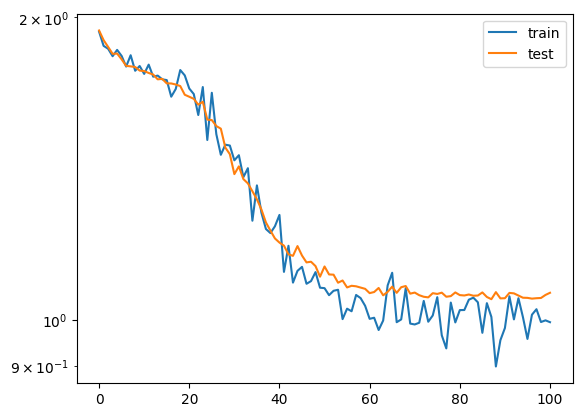

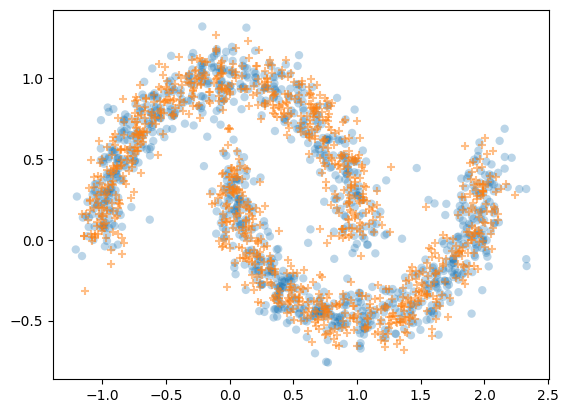

In [2]:
neural_spline_coupling = NeuralSplineCoupling()

flow = Flow(
    chain(
        ShiftBounds(margin=1e-5),
        neural_spline_coupling,
        Roll(),
        neural_spline_coupling.copy(),
    ),
    dist.Uniform(),
)

variables, best_epoch, train_losses, test_losses = train(
    flow, X_train, X_test, epochs=200
)
print(test_losses[best_epoch])

plt.figure()
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.semilogy()
plt.legend()

plt.figure()
Xm = flow.apply(variables, 1000, method="sample")
plt.scatter(*Xm.T, marker="o", ec="none", alpha=0.3)
plt.scatter(*X_test[:1000].T, marker="+", alpha=0.5);

Let's see how the base distribution is successively transformed into the target distribution.

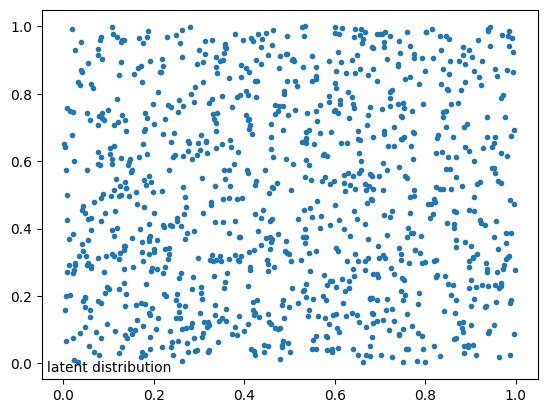

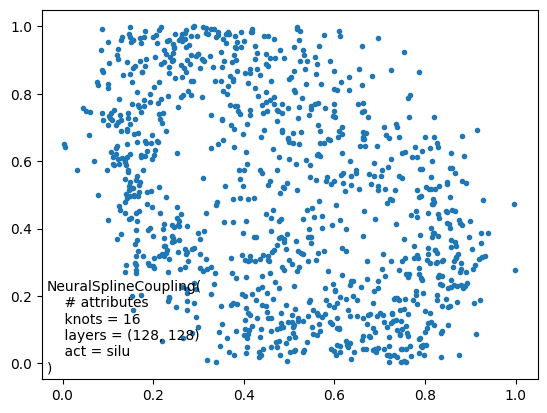

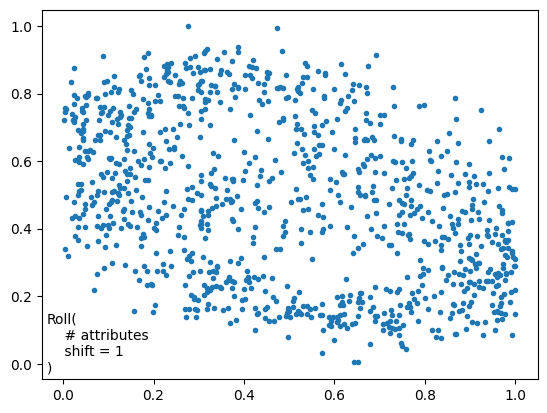

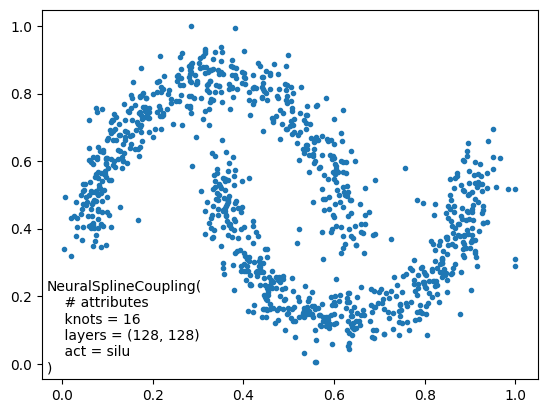

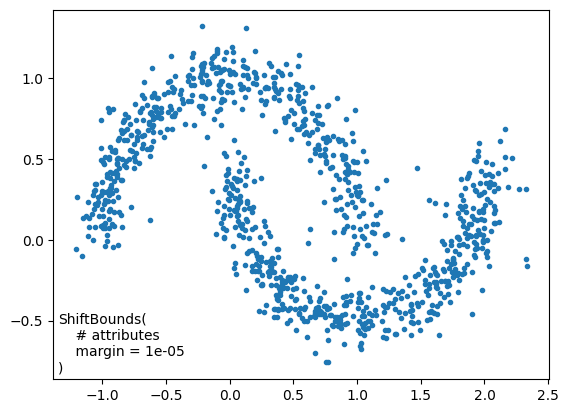

In [3]:
size = 1000
x = flow.latent.sample(size, jax.random.PRNGKey(0))

plt.figure()
plt.scatter(*x.T, marker=".")
plt.text(0.01, 0.02, "latent distribution", transform=plt.gca().transAxes)

for bi, x in zip(
    flow.bijector[::-1], flow.apply(variables, x, inverse=True, method="_steps")
):
    plt.figure()
    plt.scatter(*x.T, marker=".")
    plt.text(0.01, 0.02, f"{bi!r}", transform=plt.gca().transAxes)

Likewise, we can follow how the target distribution is converted step-by-step into the latent distribution.

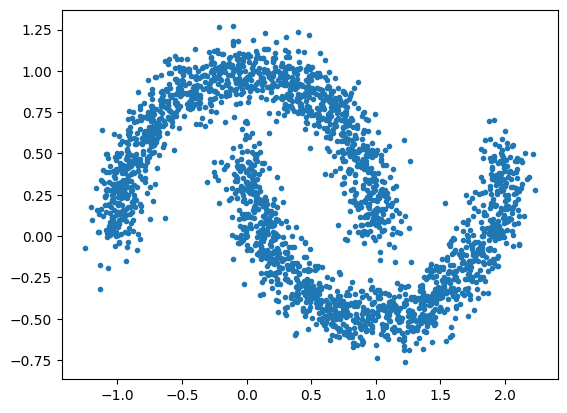

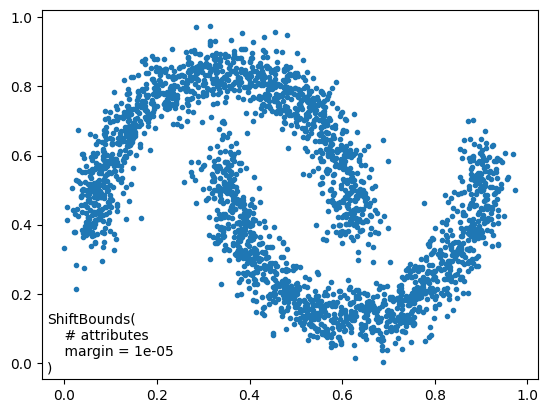

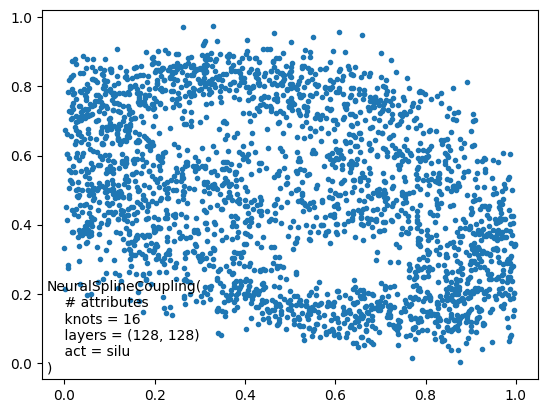

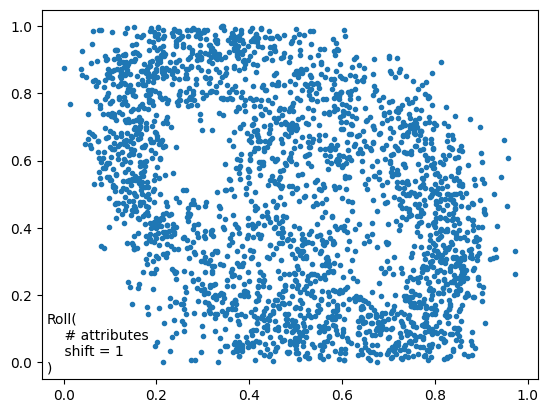

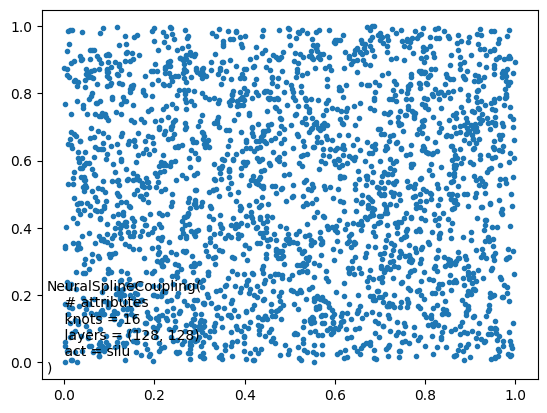

In [4]:
x = X_test

plt.figure()
plt.scatter(*x.T, marker=".")

for bi, x in zip(
    flow.bijector, flow.apply(variables, x, inverse=False, method="_steps")
):
    plt.figure()
    plt.scatter(*x.T, marker=".")
    plt.text(0.01, 0.02, f"{bi!r}", transform=plt.gca().transAxes)